In [1]:
from opal import load_dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sampler_check import *

from pyOPALTools.surrogate.uqtk_model import UQTk as UQ
from pyOPALTools.surrogate.chaospy_model import UQChaospy as CH

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
save_figures = False

fig_path = './figures2/'

------------------------

# Define some useful functions

In [3]:
def train_test(x,y):
    xtrain=[]
    ytrain=[]
    xtest= []
    ytest= []

    for ydata in y:
        x_train, x_test, y_train, y_test = train_test_split(x, ydata, test_size=0.2, random_state=42)
        xtrain.append(x_train)
        ytrain.append(y_train)
        xtest.append(x_test)
        ytest.append(y_test)

    return xtrain, ytrain, xtest, ytest;

In [4]:
def create_model(xtrain, ytrain, xtest, n_qoi, pol_order):

    uq = []
    yhat_train = []
    yhat_test = []
    sens_t = []
    sens_m = []
    
    for i in range(n_qoi):

        model = None

        model = UQ(pdom, order=pol_order, method='lsq')

        model.fit(xtrain[i], ytrain[i])

        uq.append(model)

        yhat_train.append(model.predict(xtrain[i]))

        yhat_test.append(model.predict(xtest[i]))

        sens_t.append(model.total_sensitivity())
        sens_m.append(model.main_sensitivity())
        
    return uq, yhat_train, yhat_test, sens_m, sens_t

In [5]:
def fit_eval(y, ytrain, ytest, yhat_train, yhat_test, labels, hat, savename=None, save=False):
    
    # Fit plots
    
    for i in range(len(y)):
        plt.figure(figsize=(5,5))
        line = np.linspace(min(y[i]), max(y[i]), 10)
        plt.scatter(ytrain[i], yhat_train[i], s=3, c='b')
        plt.scatter(ytest[i], yhat_test[i], s=3, c='r')
        plt.xlabel(labels[i], fontsize=19)
        plt.ylabel(hat[i], fontsize=19)
        plt.ticklabel_format(axis='both', style='sci',scilimits=(0,0), useMathText=True)
        plt.plot(line, line, 'g--')
        plt.legend(['$\hat{y}=y$','Training data', 'Testing data'], fontsize=12)
        if save:
            plt.savefig(fig_path+savename[i]+'_fit.pdf', dpi=500, bbox_inches = "tight")
        plt.show()
        
    # Rsquared values
    
    Rsquared = []
    
    for j in range(len(y)):
        SSt = 0
        SSres = 0

        for i,num in enumerate(ytrain[j]):
            SSt = SSt + (num-np.mean(ytrain[j]))**2
            SSres = SSres + (ytrain[j][i] - yhat_train[j][i])**2

        R= 1-SSres/SSt
        Rsquared.append(R)
        
    # Errors
    
    mae_test = []
    mse_test = []
    mae_train = []
    mse_train = []

    for i, data in enumerate(ytest):
        mae_test.append(100*mean_absolute_error(data, yhat_test[i])/np.mean(data))
        mse_test.append(100*mean_squared_error(data, yhat_test[i])/np.mean(data))

    for i, data in enumerate(ytrain):
        mae_train.append(100*mean_absolute_error(data, yhat_train[i])/np.mean(data))
        mse_train.append(100*mean_squared_error(data, yhat_train[i])/np.mean(data))

    errors = pd.DataFrame(list(zip(mae_train, mae_test, mse_train, mse_test)), index =labels,
                           columns = ['MAE train', 'MAE test', 'MSE train', 'MSE test'])

    
    return Rsquared, errors

In [6]:
# Function that sets up the sobol indices for the sensitivity analysis bar plots

def bar_plot(sens_m, sens_t, n_var, n_qoi):

    sm = []
    st = []

    for i in range(n_var):
        sim = []
        sit = []
        for j in range(n_qoi):
            sim.append(sens_m[j][i])
            sit.append(sens_t[j][i])
        sm.append(sim)
        st.append(sit)

    bottom_m = []
    bottom_t = []

    for i in range(n_var):

        add_m = [0]*n_qoi
        add_t = [0]*n_qoi

        for j in range(i):
            add_m = [add_m[k] + sm[j][k] for k in range(len(sm[j]))]
            add_t = [add_t[k] + st[j][k] for k in range(len(st[j]))]
            
        bottom_m.append(add_m)
        bottom_t.append(add_t)

    return sm, st, bottom_m, bottom_t

In [7]:
def sensitivity_plot(sens_m, sens_t, n_var, n_qoi, label_dvar, labels, savename='sens', save=False, print_legend=True):
    
    ind = np.linspace(0,n_qoi*2, n_qoi, endpoint=False)
    width = 1.3

    sm, st, bottom_m, bottom_t = bar_plot(sens_m, sens_t, n_var, n_qoi)

    pt = []
    
    plt.figure(figsize=(6,5))
    
    for i in range(n_var):
        pi = plt.bar(ind, st[i], width, bottom = bottom_t[i])
        pt.append(pi)

    plt.ylabel('Total Sensitivity', fontsize=15)
    plt.xticks(ind, labels, fontsize=16)
    plt.xlim(-0.65,ind[-1]+0.65)
    leg = []
    for i in range(n_var):
        leg.append(pt[i][0])
    
    if print_legend:
        plt.legend(leg, label_dvar, bbox_to_anchor=(1, 1.05), fontsize=14)
    
    if save:
        plt.savefig(fig_path + savename + '.pdf', dpi=500, bbox_inches = "tight")

    plt.show()

------------------------

# Load the json file with the design variables + objectives data

In [8]:
# number of turns in simulation
turns=95

# path where the sampler has created the output files 
path = '/data/project/general/isodarUQ/1000_6_95_uniform_numPart/output/'

# load the .json file, which contains design variable & objectives information
sampler = load_dataset(path, fname = 'IsoDAR60MeV_samples_0.json')

print(sampler)


	Sampler dataset.

	Number of samplers:  1

	Number of samples: 1000 per generation 

	Available design variables (6) :

	pr0                 
	r0                  
	rfphi               
	sigmax              
	sigmay              
	sigmaz              

	Available objectives (10) :

	EMIT_S              
	EMIT_X              
	EMIT_Y              
	HALO_X              
	HALO_Y              
	HALO_Z              
	NUM_PART            
	RMS_S               
	RMS_X               
	RMS_Y               



In [9]:
N = sampler.size


# Create a dataframe that contains the values for each design variable

names_dvar = sampler.design_variables
n_var = len(names_dvar)

dvars = pd.DataFrame(columns=names_dvar)

for i in range(N):
    dvars = dvars.append(sampler.getData(var='', ind= i), ignore_index=True)
    
label_dvar = ['$p_{r0}$ [$\\beta\gamma$]', '$r_0$ [mm]', '$\phi_{RF}$ [deg]',
              '$\sigma_x$ [m]', '$\sigma_y$ [m]', '$\sigma_z$ [m]']


# Domain of interest of the design variables (can be obtained from sampler.bounds)
pdom =np.array([[2.254e-03, 1.159e+02, 2.830e+02, 9.500e-04, 2.850e-03, 4.750e-03],
                [2.346e-03, 1.199e+02, 2.870e+02, 1.050e-03, 3.150e-03, 5.250e-03]])


# Create a list that contains the values for each objective

names_qoi = sampler.objectives
n_qoi = len(names_qoi)

names_qoi = ['EMIT_X', 'EMIT_Y', 'EMIT_S', 'HALO_X', 'HALO_Y', 'HALO_Z', 'RMS_X','RMS_Y', 'RMS_S', 'NUM_PART']

In [10]:
labels = ['$\epsilon_x$', '$\epsilon_y$', '$\epsilon_z$', '$h_x$', '$h_y$', '$h_z$',
          '$\sigma_x$', '$\sigma_y$', '$\sigma_z$', '$N_{part}$']

labels_units = ['$\epsilon_x$ [mm$\cdot$mrad]', '$\epsilon_y$ [mm$\cdot$mrad]', '$\epsilon_z$ [mm$\cdot$mrad]', '$h_x$ [-]',
                '$h_y$  [-]', '$h_z$ [-]', '$\sigma_x$ [m]', '$\sigma_y$ [m]', '$\sigma_z$ [m]', '$N_{part}$']

hat = ['$\hat{\epsilon_x}$ [mm$\cdot$mrad]', '$\hat{\epsilon_y}$ [mm$\cdot$mrad]', '$\hat{\epsilon_z}$ [mm$\cdot$mrad]',
       '$\hat{h_x}$ [-]','$\hat{h_y}$  [-]', '$\hat{h_z}$ [-]',
       '$\hat{\sigma_x}$ [m]', '$\hat{\sigma_y}$ [m]', '$\hat{\sigma_z}$ [m]', '$\hat{N_{part}}$']


y = []
idx = []

for name in names_qoi:    
    for i in range(N):
        obj = float(sampler.getData(var=name, ind=i))
        
        # remove infs from the objectives, and for the emittances, remove too small emittances (<1e-8)
        
        if name[0:4]=='EMIT':
            if (obj == float('inf')) or (obj < 1e-08):
                if i not in idx:
                    idx.append(i)
        else:
            if (obj == float('inf')):
                if i not in idx:
                    idx.append(i)                    

for name in names_qoi: 
    
    ydata = []
    
    for i in range(N):
        obj = float(sampler.getData(var=name, ind=i))
        
        if i not in idx:
            ydata.append(obj)
            
    print(len(ydata))
    
    y.append(ydata)
    
    
N = N - len(idx)


dvars.drop(list(idx), inplace=True)

x = np.vstack(dvars.to_numpy())

987
987
987
987
987
987
987
987
987
987


In [11]:
names_qoi = ['EMIT_X', 'EMIT_Y', 'EMIT_Z', 'HALO_X', 'HALO_Y', 'HALO_Z', 'RMS_X','RMS_Y', 'RMS_Z', 'NUM_PART']

In [12]:
# Scaled vector with just the emittances multiplied by 10^6 to change units to mm mrad: 

yunit = []

for i in range(n_qoi):
    if names_qoi[i][0:4]=='EMIT':
        
        new_y = []
        
        for j in range(len(y[0])):
            new_y.append(y[i][j]*1e6)
            
        yunit.append(new_y)
        
    else:
        yunit.append(y[i])
        

In [13]:
for i,num in enumerate(yunit[9]):
    yunit[9][i] = 20000 - num

------------------------

# Histogram of the outputs in order to see whether they make physical sense

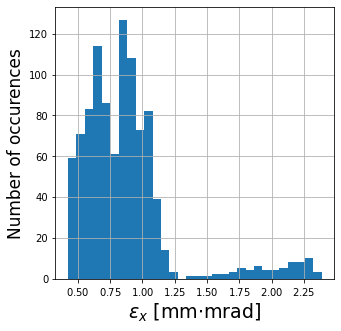

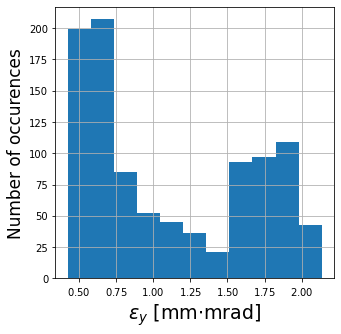

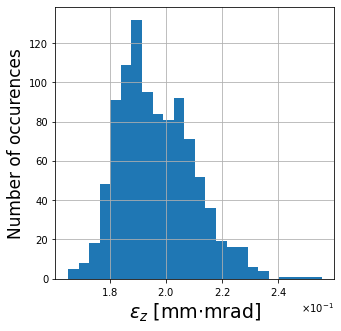

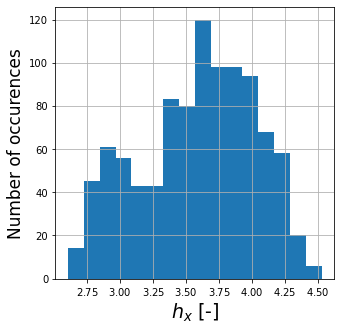

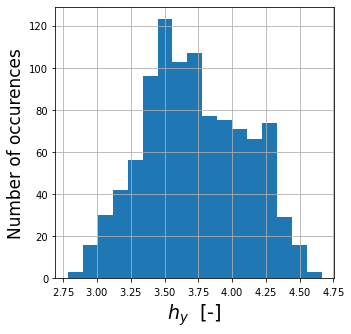

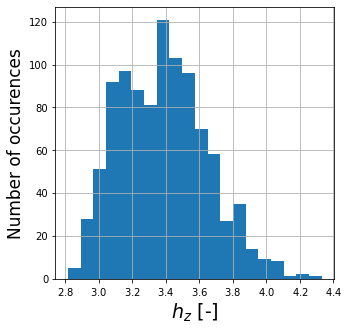

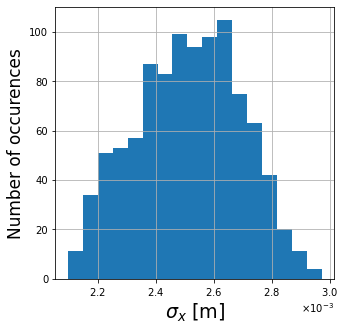

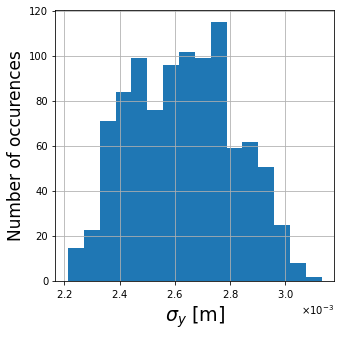

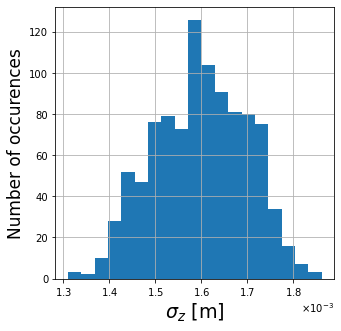

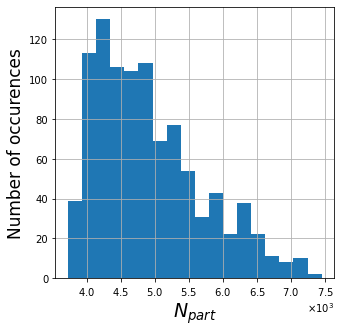

In [14]:
for i in range(n_qoi):
    plt.figure(figsize=(5,5))
    plt.hist(yunit[i], bins='auto')
    plt.ticklabel_format(axis='x', style='sci',scilimits=(0,0), useMathText=True)
    plt.xlabel(labels_units[i], fontsize=19)
    plt.ylabel('Number of occurences', fontsize=17)
    if save_figures:
        plt.savefig(fig_path + 'hist_'+names_qoi[i]+'.pdf', dpi = 500, bbox_inches = "tight")
    plt.grid()
    plt.show()

------------------------

# Surrogate model

In [15]:
xtrain, ytrain, xtest, ytest = train_test(x, yunit)

### UQTk model

In [16]:
uq3, yhat_train3, yhat_test3, sm3, st3 = create_model(xtrain, ytrain, xtest, n_qoi, 3)

### How good is the fit?

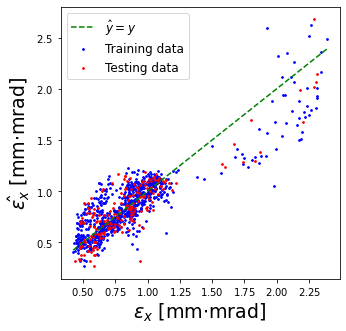

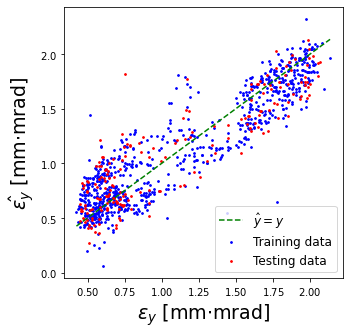

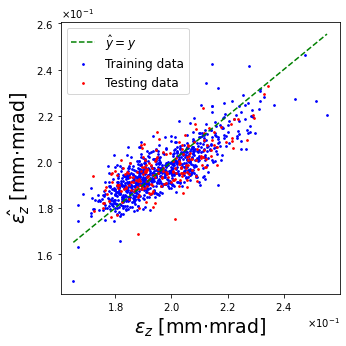

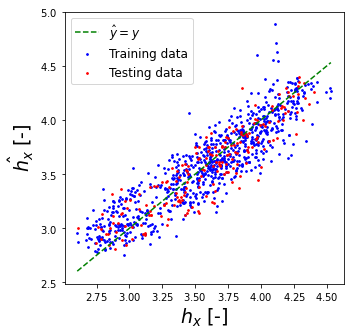

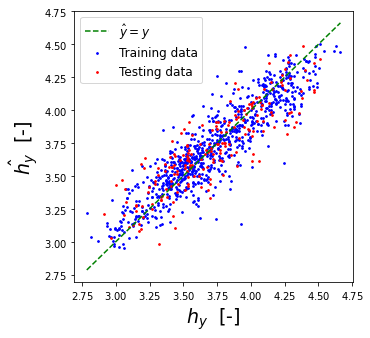

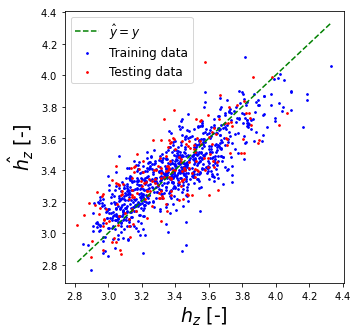

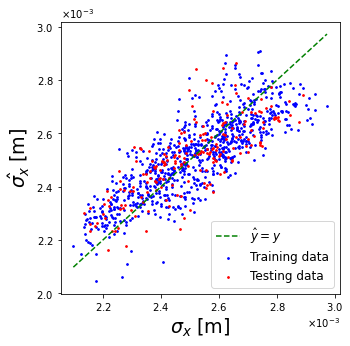

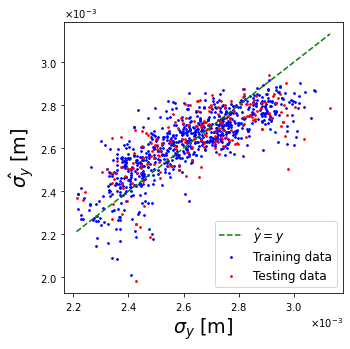

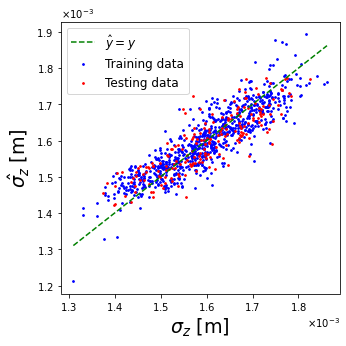

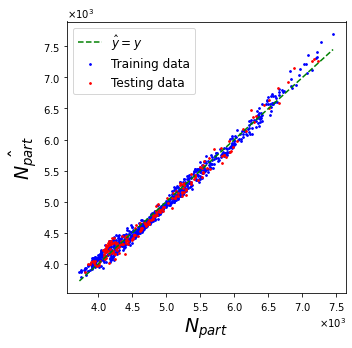

In [17]:
Rsquared3, errors3 = fit_eval(yunit, ytrain, ytest, yhat_train3, yhat_test3, labels_units, hat,
                              savename=names_qoi, save=save_figures)

In [18]:
print(Rsquared3)

[0.7804977085131661, 0.8399333237702863, 0.6660572678843095, 0.8117524539878611, 0.8142416658735774, 0.697467409495896, 0.6768216486010961, 0.6403808366248003, 0.784202921759467, 0.9886110378170541]


In [19]:
errors3

,MAE train,MAE test,MSE train,MSE test
$\epsilon_x$ [mm$\cdot$mrad],13.854507,15.423641,3.419818,3.610654
$\epsilon_y$ [mm$\cdot$mrad],15.301986,17.810649,4.247777,5.405010
$\epsilon_z$ [mm$\cdot$mrad],3.120708,3.620071,0.031169,0.038508
$h_x$ [-],4.224236,4.020150,1.028776,0.918750
$h_y$ [-],3.342483,3.761403,0.705631,0.891581
$h_z$ [-],3.342601,3.946721,0.605454,0.815477
$\sigma_x$ [m],3.329716,3.669275,0.000427,0.000496
$\sigma_y$ [m],3.415383,3.804213,0.000493,0.000625
$\sigma_z$ [m],2.351294,2.590530,0.000138,0.000166
$N_{part}$,1.417527,1.599257,145.064848,183.422485


------------

# Sensitivity analysis

In [20]:
print(sm3)
print(st3)

[array([0.04313369, 0.04726423, 0.284148  , 0.00159628, 0.00177048,
       0.00202386]), array([4.40696455e-03, 8.25558091e-03, 8.23508318e-01, 1.17102255e-03,
       3.89179127e-04, 2.47829916e-03]), array([0.0659422 , 0.21552792, 0.04347227, 0.00552157, 0.00609362,
       0.02828505]), array([0.11737835, 0.16899758, 0.45120893, 0.00340253, 0.00180812,
       0.00760512]), array([0.00177867, 0.08602014, 0.49202742, 0.00419013, 0.00136808,
       0.02418305]), array([0.06338336, 0.23122625, 0.00296986, 0.01862908, 0.03224227,
       0.05123193]), array([0.03572993, 0.17470071, 0.30375158, 0.00440025, 0.00212997,
       0.007823  ]), array([0.07324225, 0.16447771, 0.50472127, 0.00583375, 0.00335546,
       0.00485807]), array([5.72459249e-02, 4.04357374e-03, 5.08590437e-01, 1.03783838e-03,
       8.21819860e-04, 3.61882220e-04]), array([2.48544941e-03, 9.37886759e-01, 3.49188877e-03, 3.91316344e-04,
       1.66463960e-02, 9.31351169e-03])]
[array([0.3951231 , 0.40734317, 0.82756859, 0.0

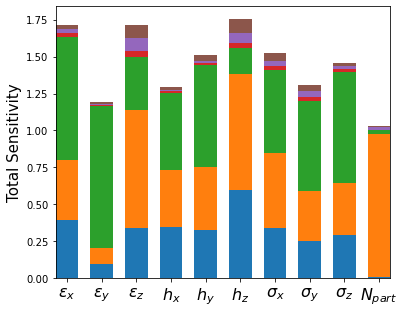

In [21]:
# ORDER 3

sensitivity_plot(sm3, st3, n_var, n_qoi, label_dvar, labels, savename='sens3', save=save_figures, print_legend=False)

## Compare Sobol indices for order 2,3, and 4

In [22]:
uq2, yhat_train2, yhat_test2, sm2, st2 = create_model(xtrain, ytrain, xtest, n_qoi, 2)
uq4, yhat_train4, yhat_test4, sm4, st4 = create_model(xtrain, ytrain, xtest, n_qoi, 4)

In [23]:
uq1, yhat_train1, yhat_test1, sm1, st1 = create_model(xtrain, ytrain, xtest, n_qoi, 1)
uq5, yhat_train5, yhat_test5, sm5, st5 = create_model(xtrain, ytrain, xtest, n_qoi, 5)

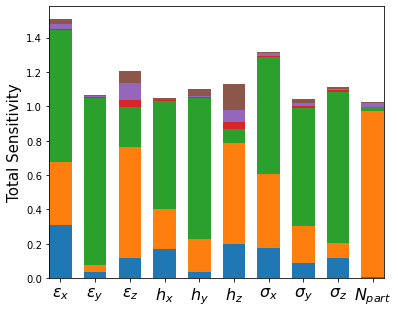

In [24]:
# ORDER 2

sensitivity_plot(sm2, st2, n_var, n_qoi, label_dvar, labels, savename='sens2', save=save_figures, print_legend=False)

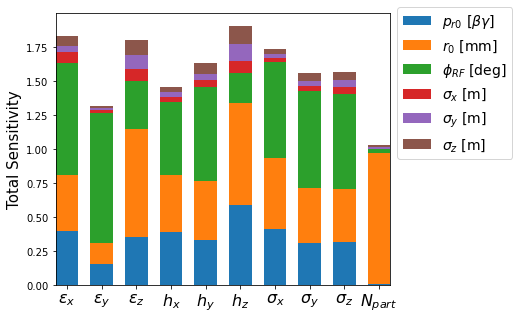

In [25]:
# ORDER 4

sensitivity_plot(sm4, st4, n_var, n_qoi, label_dvar, labels, savename='sens4', save=save_figures, print_legend=True)

------------

# MAE vs. order (from 1 to 5) plots

In [26]:
%%capture

Rsquared1, errors1 = fit_eval(yunit, ytrain, ytest, yhat_train1, yhat_test1, labels_units, hat)

In [27]:
%%capture

Rsquared2, errors2 = fit_eval(yunit, ytrain, ytest, yhat_train2, yhat_test2, labels_units, hat)

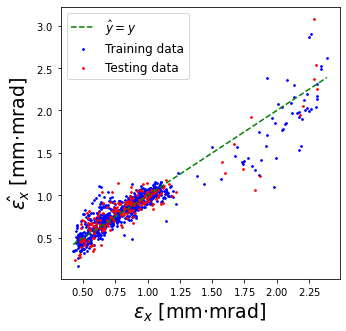

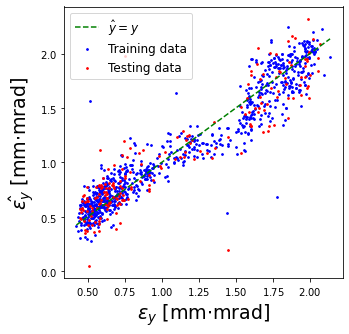

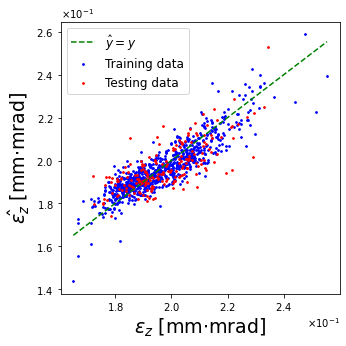

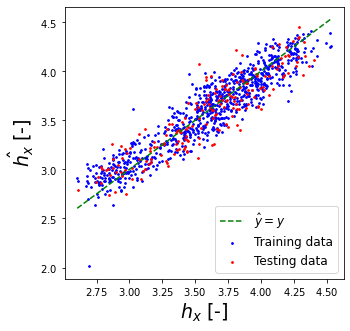

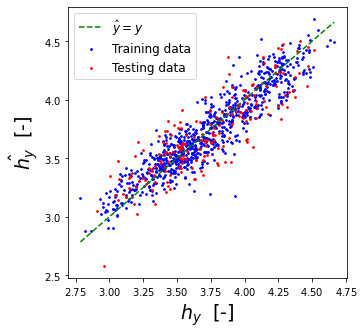

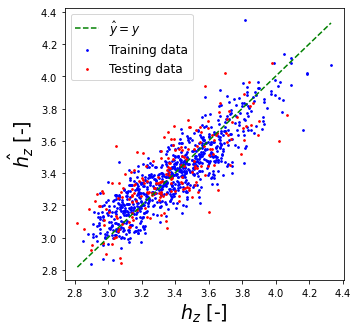

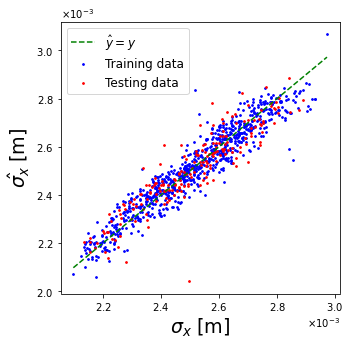

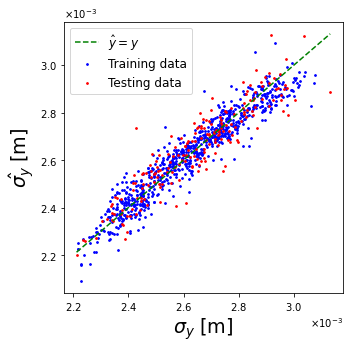

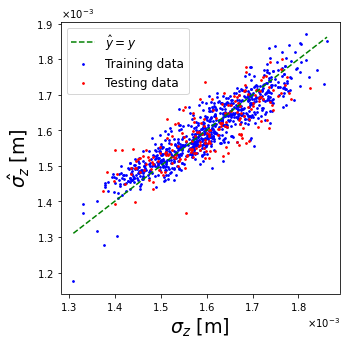

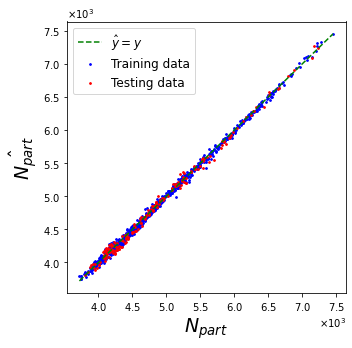

In [28]:

Rsquared4, errors4 = fit_eval(yunit, ytrain, ytest, yhat_train4, yhat_test4, labels_units, hat)

In [29]:
%%capture

Rsquared5, errors5 = fit_eval(yunit, ytrain, ytest, yhat_train5, yhat_test5, labels_units, hat)

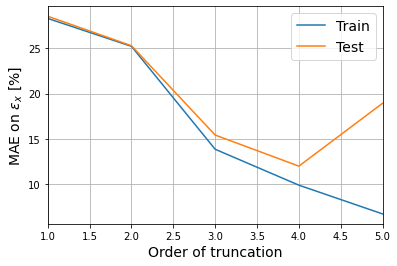

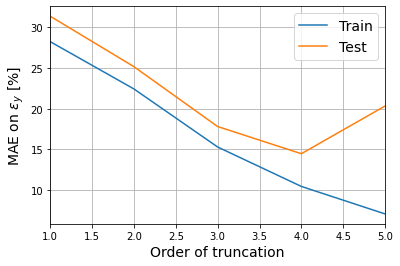

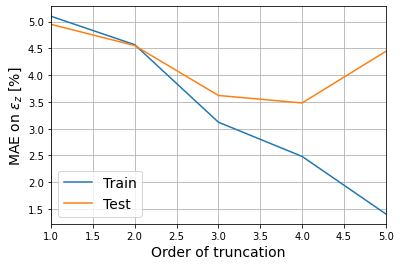

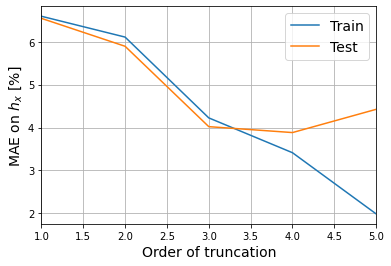

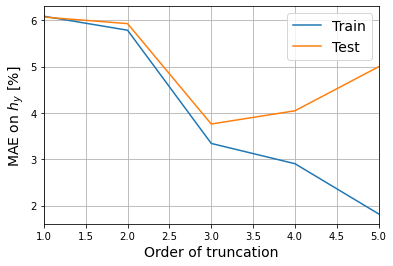

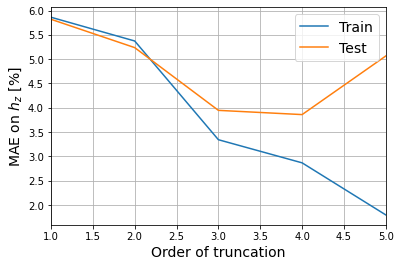

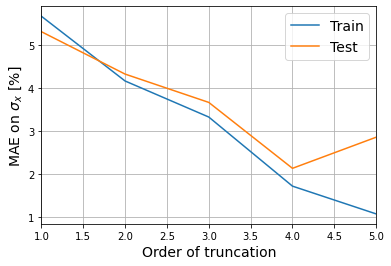

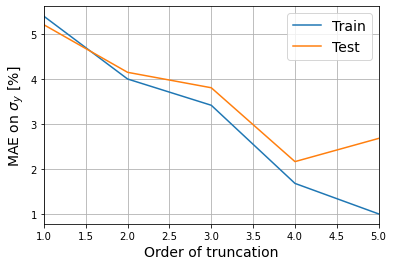

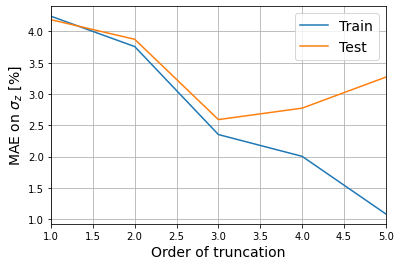

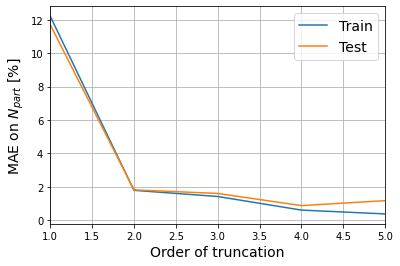

In [30]:
orders = [1,2,3,4,5]

for i in range(n_qoi):
    err_test = [errors1.iloc[i][1], errors2.iloc[i][1], errors3.iloc[i][1], errors4.iloc[i][1], errors5.iloc[i][1]]
    err_train = [errors1.iloc[i][0], errors2.iloc[i][0], errors3.iloc[i][0], errors4.iloc[i][0], errors5.iloc[i][0]]

    plt.plot(orders, err_train)
    plt.plot(orders, err_test)
    plt.xlabel('Order of truncation', fontsize=14)
    plt.xlim(1,5)
    plt.ylabel('MAE on '+labels[i]+' [%]', fontsize=14)
    plt.legend(['Train', 'Test'], fontsize=14)
    plt.grid()
    if save_figures:
        plt.savefig(fig_path+'ordervsmae'+names_qoi[i]+'.pdf', dpi=500, bbox_inches = "tight")
    plt.show()

------------

# Look at how order affects fit

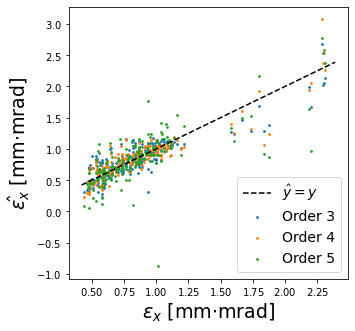

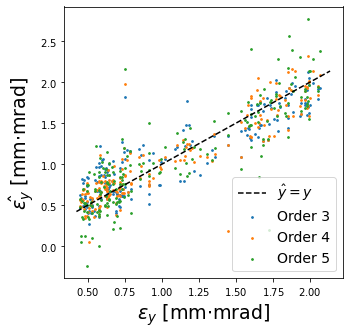

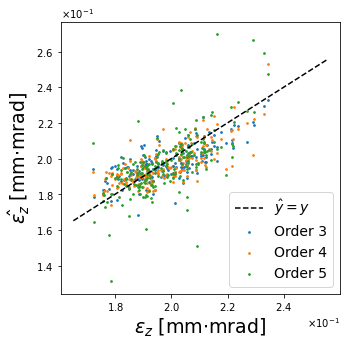

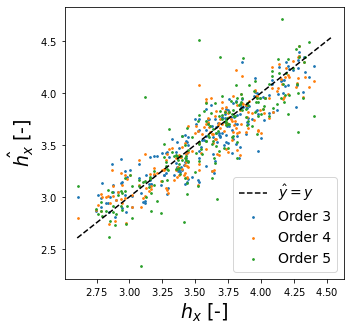

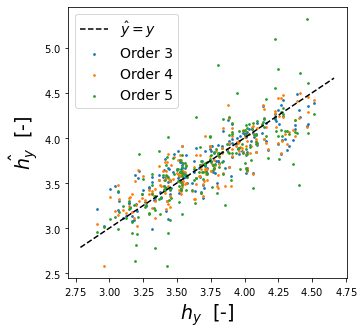

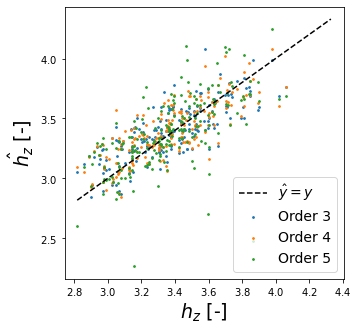

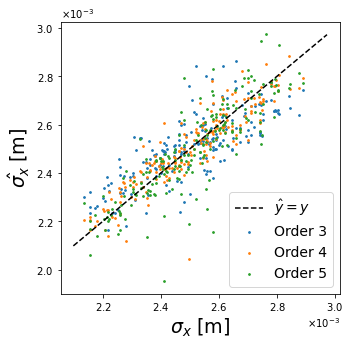

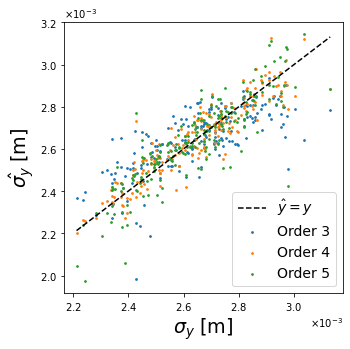

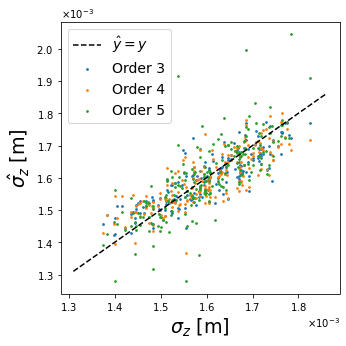

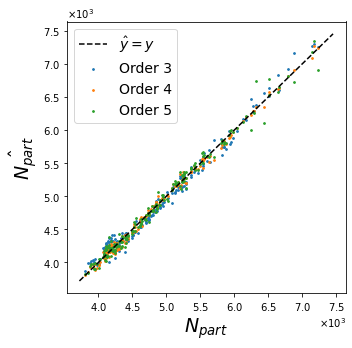

In [31]:
for i in range(n_qoi):
    plt.figure(figsize=(5,5))
    line = np.linspace(min(yunit[i]), max(yunit[i]), 10)
    plt.scatter(ytest[i], yhat_test3[i], s=3)
    plt.scatter(ytest[i], yhat_test4[i], s=3)
    plt.scatter(ytest[i], yhat_test5[i], s=3)
    plt.xlabel(labels_units[i], fontsize=19)
    plt.ylabel(hat[i], fontsize=19)
    plt.plot(line, line, 'k--')
    plt.ticklabel_format(axis='both', style='sci',scilimits=(0,0), useMathText=True)
    plt.legend(['$\hat{y}=y$','Order 3', 'Order 4', 'Order 5'], fontsize=14)
    if save_figures:
        plt.savefig(fig_path + 'ordervsfit_'+names_qoi[i]+'.pdf', dpi=500, bbox_inches = "tight")
    plt.show()

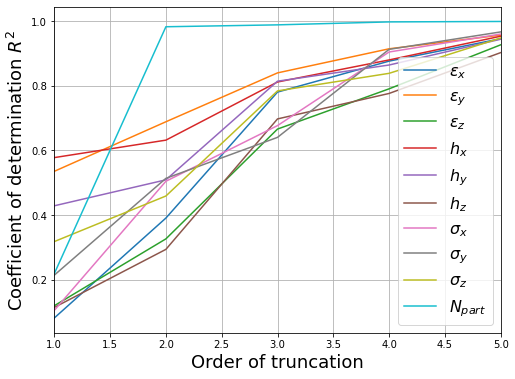

In [32]:
order=[1,2,3,4,5]
r2 = []

for i in range(n_qoi):
    r2i = []
    r2i.append(Rsquared1[i])
    r2i.append(Rsquared2[i])
    r2i.append(Rsquared3[i])
    r2i.append(Rsquared4[i])
    r2i.append(Rsquared5[i])
    
    r2.append(r2i)
    
plt.figure(figsize=(8,6))
for i in range(n_qoi):
    plt.plot(order, r2[i])
plt.xlabel('Order of truncation', fontsize=18)
plt.ylabel('Coefficient of determination $R^2$', fontsize=18)
plt.legend(labels, fontsize=16)
plt.xlim((1,5))
plt.grid()
if save_figures:
    plt.savefig(fig_path + 'r2_order.pdf', dpi=500, bbox_inches = "tight")
plt.show()

------------

# Look at how training sample size affects fit

In [33]:
%%capture

sample_size=[500,700,1000]
r2 = []
ytest_size = []
yhat_size = []

for n in sample_size:
    xsliced=x[0:n]
    ysliced=[]

    for ydat in yunit:
        ysliced.append(ydat[0:n])

    xtrainn, ytrainn, xtestn, ytestn = train_test(xsliced, ysliced)
    uqn, yhat_trainn, yhat_testn, smn, stn = create_model(xtrainn, ytrainn, xtestn, n_qoi, 3)
    
    ytest_size.append(ytestn)
    
    yhat_size.append(yhat_testn)
    
    rsq,err = fit_eval(ysliced, ytrainn, ytestn, yhat_trainn, yhat_testn, labels_units,hat, save=False);
    
    r2.append(rsq)
    

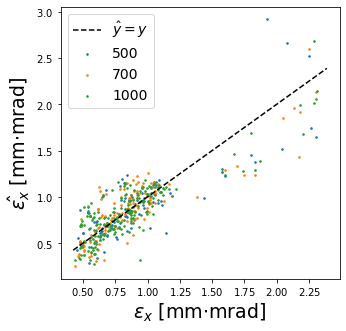

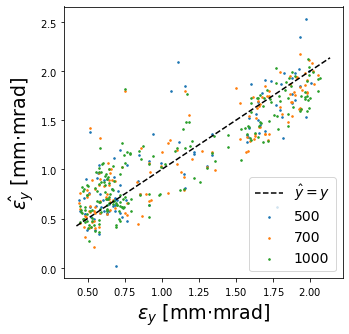

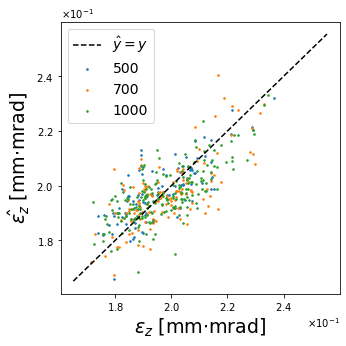

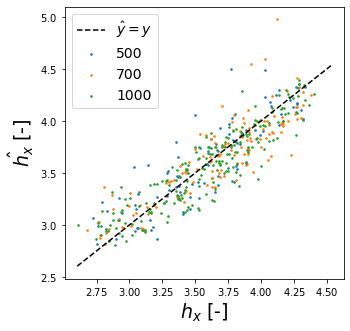

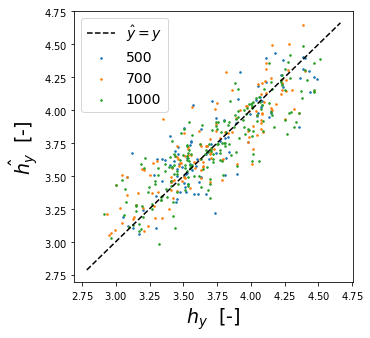

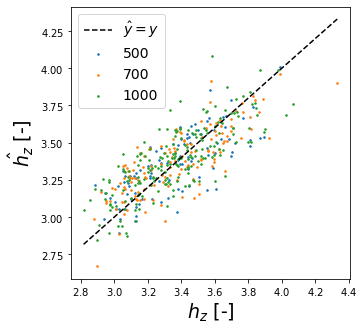

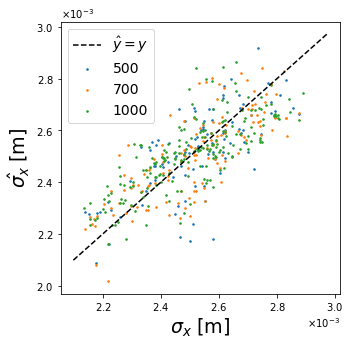

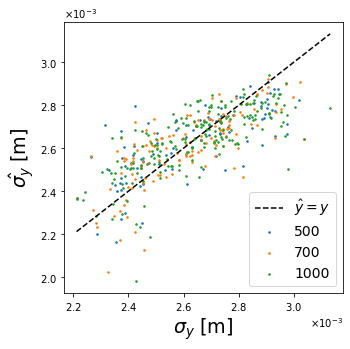

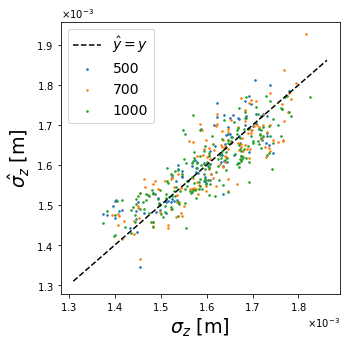

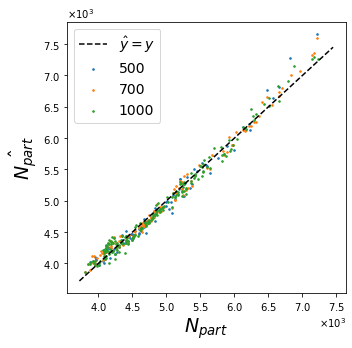

In [34]:
for i in range(n_qoi):
    plt.figure(figsize=(5,5))
    line = np.linspace(min(yunit[i]), max(yunit[i]), 10)
    
    for j in range(len(sample_size)):
        plt.scatter(ytest_size[j][i], yhat_size[j][i], s=2.5)
    
    plt.xlabel(labels_units[i], fontsize=19)
    plt.ylabel(hat[i], fontsize=19)
    plt.plot(line, line, 'k--')
    plt.ticklabel_format(axis='both', style='sci',scilimits=(0,0), useMathText=True)
    plt.legend(['$\hat{y}=y$', '500','700', '1000'], fontsize=14)
    if save_figures:
        plt.savefig(fig_path + 'sizevsfit_'+names_qoi[i]+'.pdf', dpi=500, bbox_inches = "tight")
    plt.show()

In [35]:
r2plot = []

for i in range(n_qoi):
    plot = []
    for n in range(len(sample_size)):
        plot.append(r2[n][i])
    r2plot.append(plot)

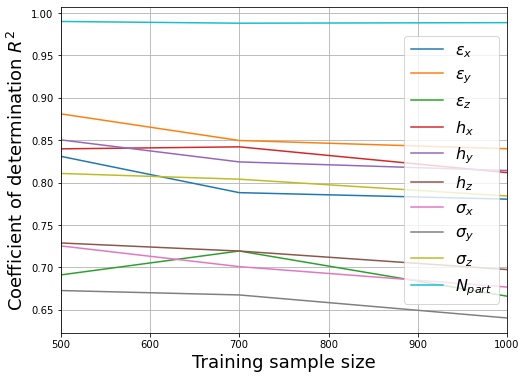

In [36]:
plt.figure(figsize=(8,6))
for i in range(n_qoi):
    plt.plot(sample_size, r2plot[i])
plt.xlabel('Training sample size', fontsize=18)
plt.ylabel('Coefficient of determination $R^2$', fontsize=18)
plt.legend(labels, fontsize=16)
plt.xlim((500,1000))
plt.grid()
if save_figures:
    plt.savefig(fig_path+ 'r2_size.pdf', dpi=500, bbox_inches = "tight")
plt.show()

------------

# How does eliminating the bigger emittances (after the two histogram peaks) affect fit ?

In [37]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="y", labelleft=False)
    
    ax_histy.tick_params(axis="y", labelleft=False)
    
    # the scatter plot:
    ax.scatter(x, y, s=3)

    ax_histx.hist(x, bins='auto')
    ax_histy.hist(y, bins='auto', orientation='horizontal')

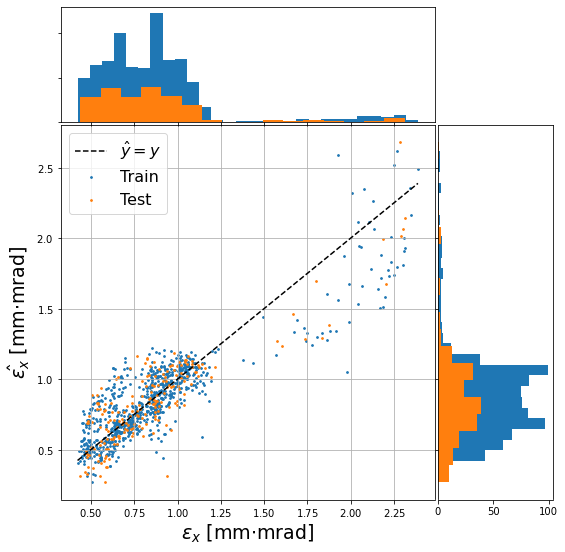

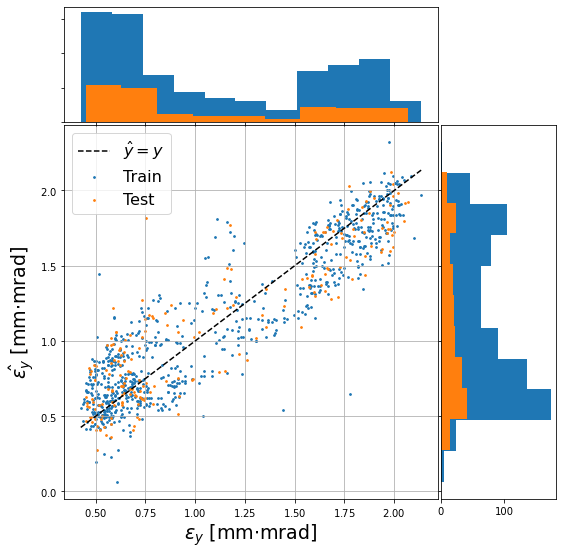

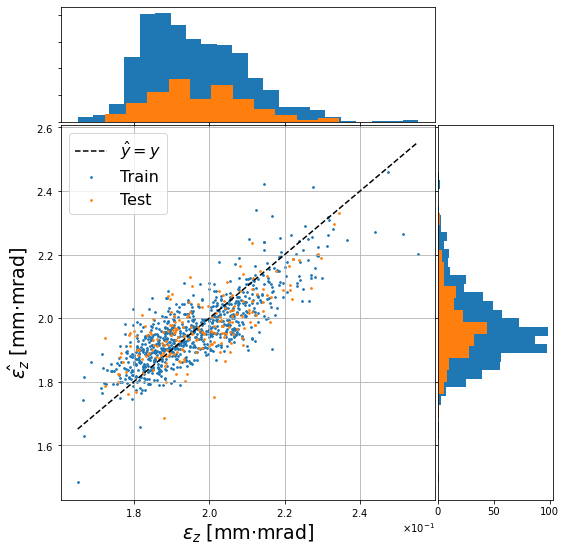

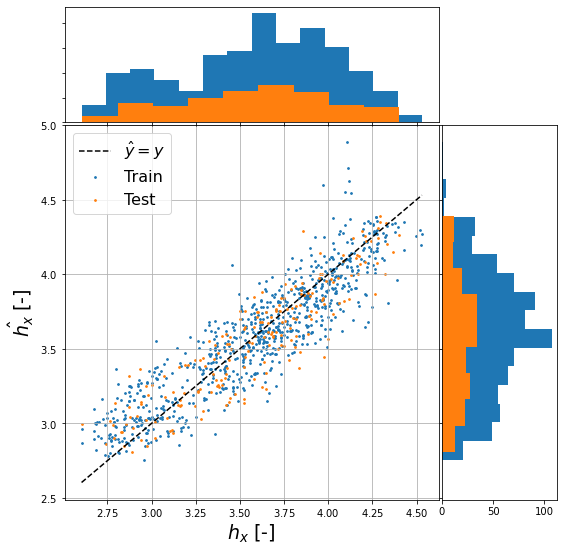

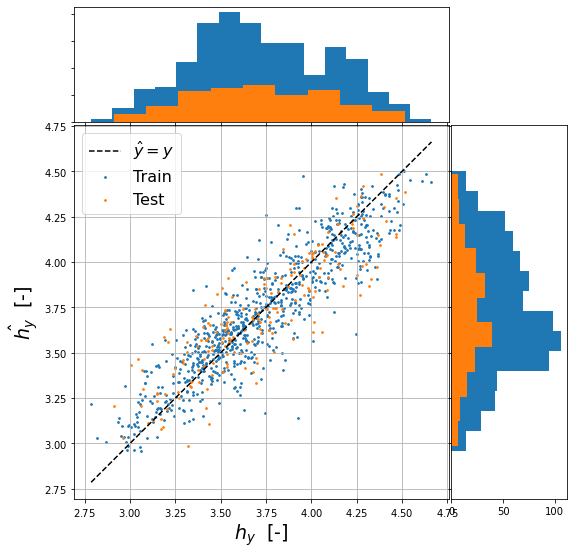

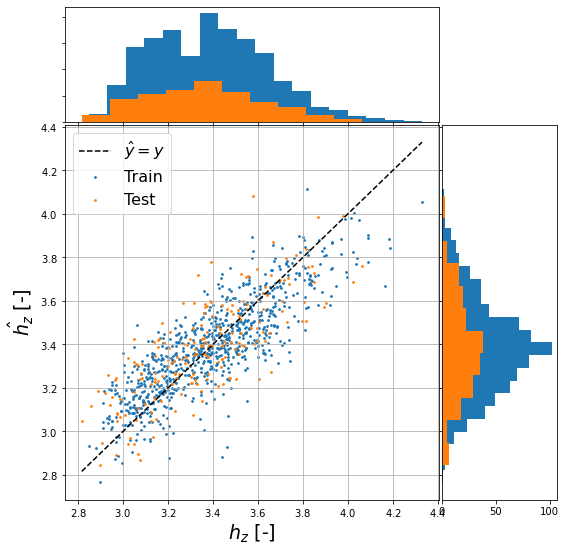

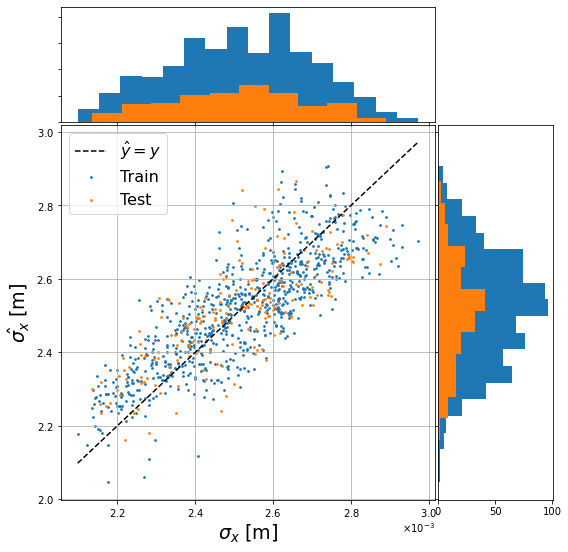

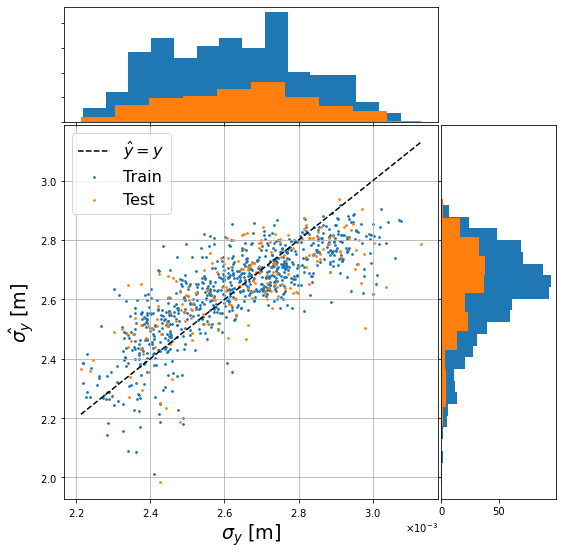

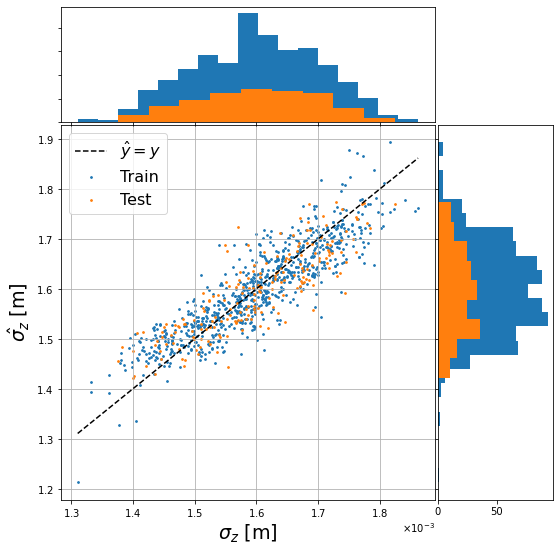

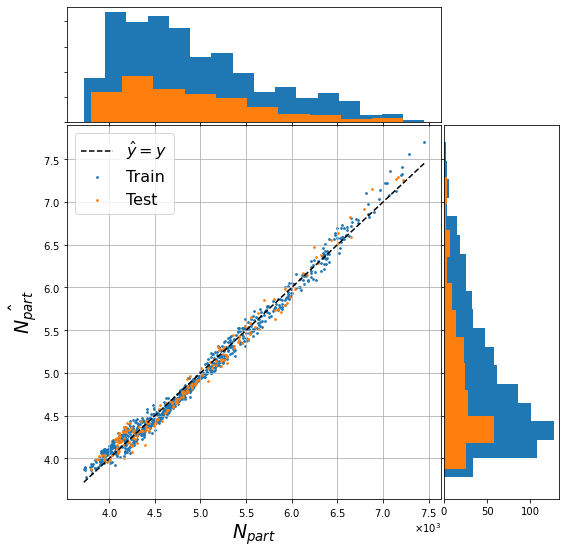

In [38]:
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

for i in range(n_qoi):

    # start with a square Figure
    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_axes(rect_scatter)

    line = np.linspace(min(yunit[i]), max(yunit[i]), 10)

    ax.plot(line,line, 'k--')
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)

    # use the previously defined function
    scatter_hist(ytrain[i], yhat_train3[i], ax, ax_histx, ax_histy)
    scatter_hist(ytest[i], yhat_test3[i], ax, ax_histx, ax_histy)

    ax.legend(['$\hat{y}=y$','Train', 'Test'], fontsize=16)
    
    ax.set_xlabel(labels_units[i], fontsize=19)
    ax.set_ylabel(hat[i], fontsize=19)
    ax.grid()
    
    if save_figures:
        plt.savefig(fig_path + 'scatter_hist_'+names_qoi[i]+'.pdf', dpi=500, bbox_inches = "tight")
    
    ax.ticklabel_format(axis='both', style='sci',scilimits=(0,0), useMathText=True)
    
    plt.show()

### We can cut off the samples that have an $\epsilon_x$ > 1.2 mm mrad since these seem to be causing the bad fit in the first plot.

In [39]:
ycut = []
idx=[]

for i in range(len(yunit[0])):
    if (yunit[0][i] >= 1.2):
        idx.append(i)

for j in range(len(yunit)):
    
    ynew=[]
    
    for i in range(len(yunit[0])):
        if i not in idx:
            ynew.append(yunit[j][i])
        
    ycut.append(ynew)

dvars_cut =  dvars.reset_index(drop=True)

dvars_cut.drop(list(idx), inplace=True)

xcut = np.vstack(dvars_cut.to_numpy())

In [40]:
xtrain_cut, ytrain_cut, xtest_cut, ytest_cut = train_test(xcut, ycut)

uq_cut, yhat_train_cut, yhat_test_cut, sm_cut, st_cut = create_model(xtrain_cut, ytrain_cut, xtest_cut, n_qoi, 3)

In [41]:
new_names = []

for name in names_qoi:
    new_names.append(name+'_cut')

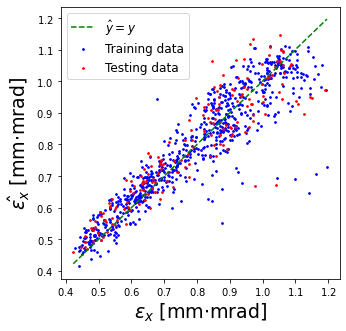

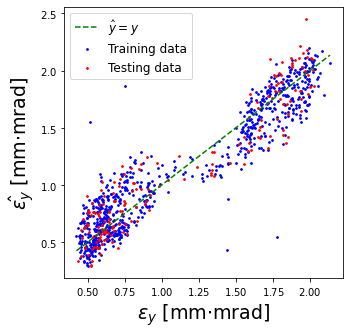

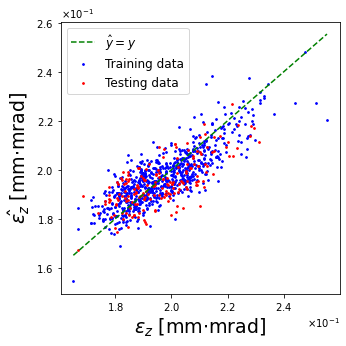

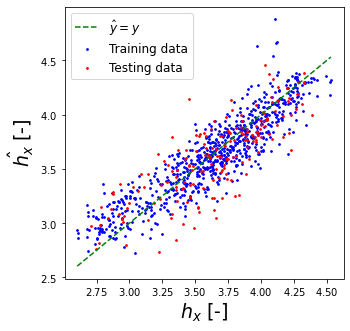

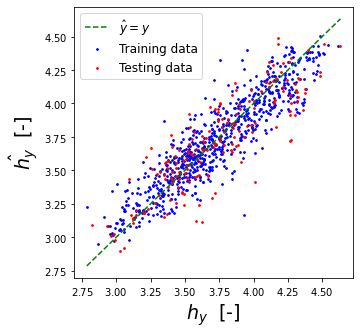

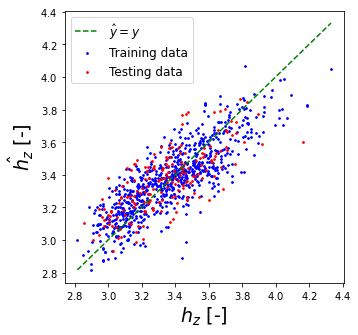

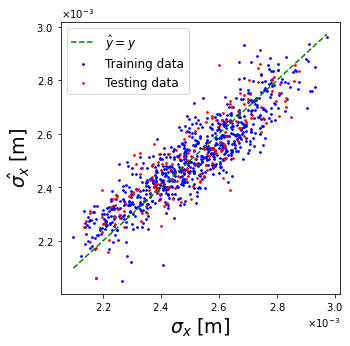

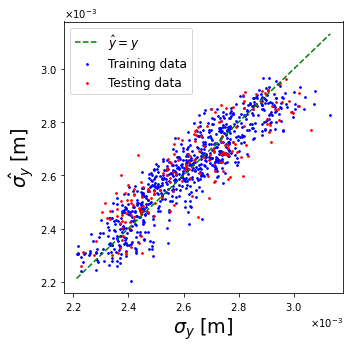

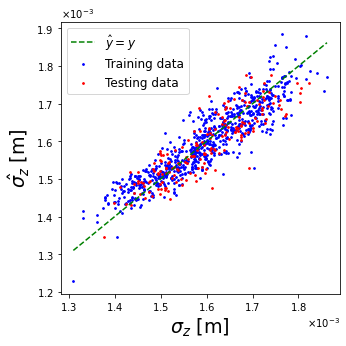

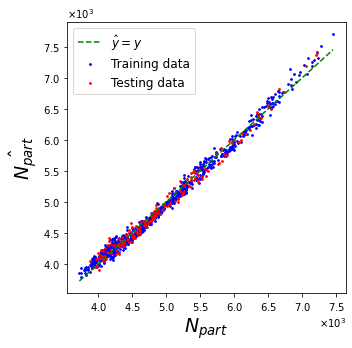

In [42]:
Rsquared_cut, errors_cut = fit_eval(ycut, ytrain_cut, ytest_cut, yhat_train_cut, yhat_test_cut, labels_units, hat,
                                    savename=new_names,save=save_figures)

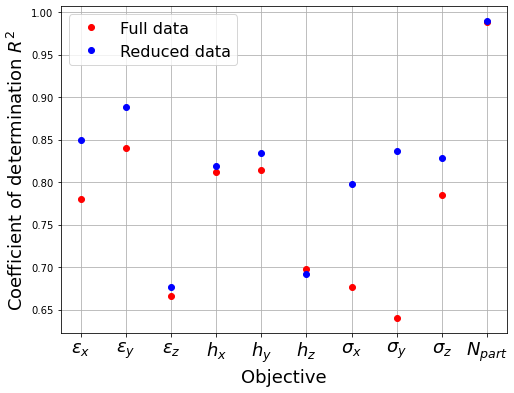

In [43]:
plt.figure(figsize=(8,6))
plt.plot(labels, Rsquared3, 'r.', markersize=12)
plt.plot(labels, Rsquared_cut, 'b.', markersize=12)
plt.xlabel('Objective', fontsize=18)
plt.ylabel('Coefficient of determination $R^2$', fontsize=18)
plt.legend(['Full data','Reduced data'], fontsize=16)
plt.xticks(fontsize=18)
plt.grid()
if save_figures:
    plt.savefig(fig_path + 'r2_cut.pdf', dpi=500, bbox_inches = "tight")
plt.show()

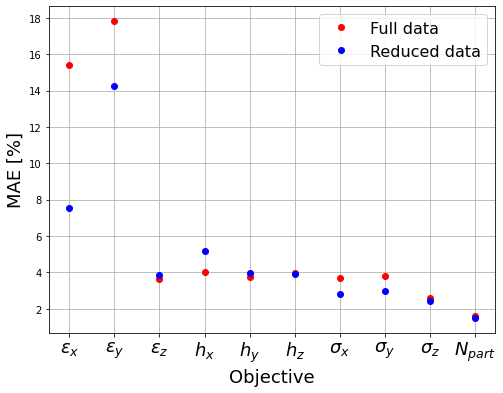

In [44]:
plt.figure(figsize=(8,6))
plt.plot(labels, errors3['MAE test'], 'r.', markersize=12)
plt.plot(labels, errors_cut['MAE test'], 'b.', markersize=12)
plt.xlabel('Objective', fontsize=18)
plt.ylabel('MAE [%]', fontsize=18)
plt.legend(['Full data','Reduced data'], fontsize=16)
plt.xticks(fontsize=18)
plt.grid()
if save_figures:
    plt.savefig(fig_path + 'mae_cut.pdf', dpi=500, bbox_inches = "tight")
plt.show()

------------

# Which region of the design variable space do these cut off emittances correspond to?

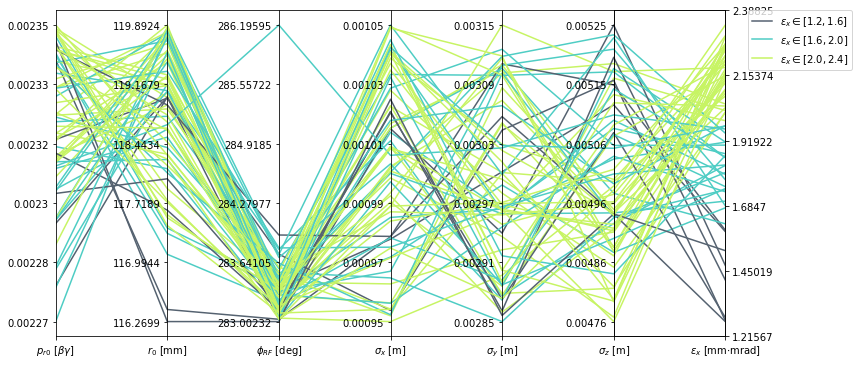

In [45]:
# Prepare the data

emit_x = []
idx=[]

for i in range(len(yunit[0])):
    if (yunit[0][i] < 1.2):
        idx.append(i)
        
for i in range(len(yunit[0])):
    if i not in idx:
        emit_x.append(yunit[0][i])
        
dvars_emit =  dvars.reset_index(drop=True)

dvars_emit.drop(list(idx), inplace=True)

dvars_emit['emit_x'] = emit_x


class_col =[]

for elem in emit_x:
    if 1.2 <= elem <=1.6:
        class_col.append("$\epsilon_x\in [1.2,1.6]$")
    elif 1.6 < elem <= 2.0:
        class_col.append("$\epsilon_x\in [1.6,2.0]$")
    elif 2.0 < elem <= 2.4:
        class_col.append("$\epsilon_x\in [2.0,2.4]$")
        
dvars_emit['range'] = class_col
dvars_emit['range'] = dvars_emit['range'].astype('category')

for name in names_dvar:
    dvars_emit[name] = dvars_emit[name].astype(float)
    
rename_dict = dict(zip(names_dvar,label_dvar))
    
dvars_emit.rename(columns = rename_dict, inplace = True) 

dvars_emit.rename(columns = {'emit_x': '$\epsilon_x$ [mm$\cdot$mrad]'}, inplace = True) 

# Parallel coordinated plot

from matplotlib import ticker

cols = [label_dvar[i] for i in range(len(label_dvar))]
cols.append('$\epsilon_x$ [mm$\cdot$mrad]')

x_plot = [i for i, _ in enumerate(cols)]
colours = ['#556270', '#4ECDC4', '#C7F464']

# create dict of categories: colours
colours = {dvars_emit['range'].cat.categories[i]: colours[i] for i, _ in enumerate(dvars_emit['range'].cat.categories)}

# Create (X-1) sublots along x axis
fig, axes = plt.subplots(1, len(x_plot)-1, sharey=False, figsize=(12,6))

# Get min, max and range for each column
# Normalize the data for each column
min_max_range = {}
for col in cols:
    min_max_range[col] = [dvars_emit[col].min(), dvars_emit[col].max(), np.ptp(dvars_emit[col])]
    dvars_emit[col] = np.true_divide(dvars_emit[col] - dvars_emit[col].min(), np.ptp(dvars_emit[col]))

# Plot each row
for i, ax in enumerate(axes):
    for idx in dvars_emit.index:
        category = dvars_emit.loc[idx, 'range']
        ax.plot(x_plot, dvars_emit.loc[idx, cols], colours[category])
    ax.set_xlim([x_plot[i], x_plot[i+1]])
    
# Set the tick positions and labels on y axis for each plot
# Tick positions based on normalised data
# Tick labels are based on original data
def set_ticks_for_axis(dim, ax, ticks):
    min_val, max_val, val_range = min_max_range[cols[dim]]
    step = val_range / float(ticks-1)
    tick_labels = [round(min_val + step * i, 5) for i in range(ticks)]
    norm_min = dvars_emit[cols[dim]].min()
    norm_range = np.ptp(dvars_emit[cols[dim]])
    norm_step = norm_range / float(ticks-1)
    ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
    ax.yaxis.set_ticks(ticks)
    ax.set_yticklabels(tick_labels)

for dim, ax in enumerate(axes):
    ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
    set_ticks_for_axis(dim, ax, ticks=6)
    ax.set_xticklabels([cols[dim]])
    

# Move the final axis' ticks to the right-hand side
ax = plt.twinx(axes[-1])
dim = len(axes)
ax.xaxis.set_major_locator(ticker.FixedLocator([x_plot[-2], x_plot[-1]]))
set_ticks_for_axis(dim, ax, ticks=6)
ax.set_xticklabels([cols[-2], cols[-1]], fontsize='xx-large')


# Remove space between subplots
plt.subplots_adjust(wspace=0)

# Add legend to plot
plt.legend(
    [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in dvars_emit['range'].cat.categories],
    dvars_emit['range'].cat.categories,
    bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

if save_figures:
    plt.savefig(fig_path + 'parallel_emitx.pdf', bbox_inches="tight", dpi=500)

plt.show()

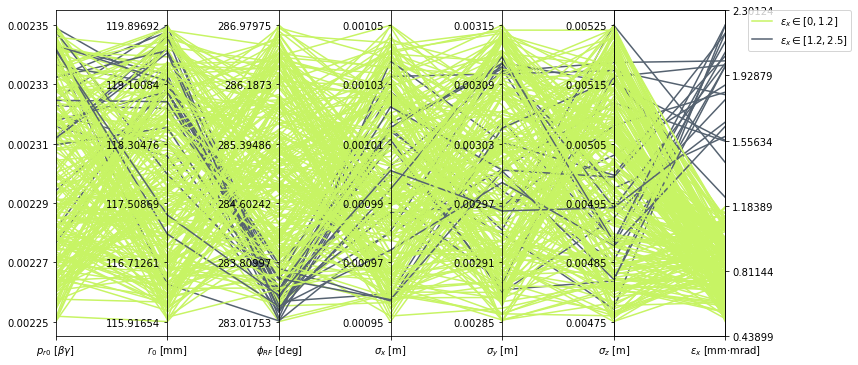

In [46]:
dvars_emit =  (dvars.head(250)).reset_index(drop=True)

dvars_emit['emit_x'] = yunit[0][:250]

class_col =[]

for elem in dvars_emit['emit_x']:
    if 0 <= elem <=1.2:
        class_col.append("$\epsilon_x\in [0,1.2]$")
    elif 1.2 < elem <= 2.5:
        class_col.append("$\epsilon_x\in [1.2,2.5]$")
        
dvars_emit['range'] = class_col
dvars_emit['range'] = dvars_emit['range'].astype('category')

for name in names_dvar:
    dvars_emit[name] = dvars_emit[name].astype(float)
    
rename_dict = dict(zip(names_dvar,label_dvar))
    
dvars_emit.rename(columns = rename_dict, inplace = True) 

dvars_emit.rename(columns = {'emit_x': '$\epsilon_x$ [mm$\cdot$mrad]'}, inplace = True) 

# Parallel coordinated plot

from matplotlib import ticker

cols = [label_dvar[i] for i in range(len(label_dvar))]
cols.append('$\epsilon_x$ [mm$\cdot$mrad]')

x_plot = [i for i, _ in enumerate(cols)]
colours = ['#C7F464','#556270']

# create dict of categories: colours
colours = {dvars_emit['range'].cat.categories[i]: colours[i] for i, _ in enumerate(dvars_emit['range'].cat.categories)}

# Create (X-1) sublots along x axis
fig, axes = plt.subplots(1, len(x_plot)-1, sharey=False, figsize=(12,6))

# Get min, max and range for each column
# Normalize the data for each column
min_max_range = {}
for col in cols:
    min_max_range[col] = [dvars_emit[col].min(), dvars_emit[col].max(), np.ptp(dvars_emit[col])]
    dvars_emit[col] = np.true_divide(dvars_emit[col] - dvars_emit[col].min(), np.ptp(dvars_emit[col]))

# Plot each row
for i, ax in enumerate(axes):
    for idx in dvars_emit.index:
        category = dvars_emit.loc[idx, 'range']
        ax.plot(x_plot, dvars_emit.loc[idx, cols], colours[category])
    ax.set_xlim([x_plot[i], x_plot[i+1]])
    
# Set the tick positions and labels on y axis for each plot
# Tick positions based on normalised data
# Tick labels are based on original data
def set_ticks_for_axis(dim, ax, ticks):
    min_val, max_val, val_range = min_max_range[cols[dim]]
    step = val_range / float(ticks-1)
    tick_labels = [round(min_val + step * i, 5) for i in range(ticks)]
    norm_min = dvars_emit[cols[dim]].min()
    norm_range = np.ptp(dvars_emit[cols[dim]])
    norm_step = norm_range / float(ticks-1)
    ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
    ax.yaxis.set_ticks(ticks)
    ax.set_yticklabels(tick_labels)

for dim, ax in enumerate(axes):
    ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
    set_ticks_for_axis(dim, ax, ticks=6)
    ax.set_xticklabels([cols[dim]])
    

# Move the final axis' ticks to the right-hand side
ax = plt.twinx(axes[-1])
dim = len(axes)
ax.xaxis.set_major_locator(ticker.FixedLocator([x_plot[-2], x_plot[-1]]))
set_ticks_for_axis(dim, ax, ticks=6)
ax.set_xticklabels([cols[-2], cols[-1]], fontsize='xx-large')


# Remove space between subplots
plt.subplots_adjust(wspace=0)

# Add legend to plot
plt.legend(
    [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in dvars_emit['range'].cat.categories],
    dvars_emit['range'].cat.categories,
    bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

if save_figures:
    plt.savefig(fig_path + 'parallel_emitx.pdf', bbox_inches="tight", dpi=500)

plt.show()

In [47]:
pdom

array([[2.254e-03, 1.159e+02, 2.830e+02, 9.500e-04, 2.850e-03, 4.750e-03],
       [2.346e-03, 1.199e+02, 2.870e+02, 1.050e-03, 3.150e-03, 5.250e-03]])

Most visible pattern: We should reduce the bounds of $\phi_{RF}$ on the lower end.

# What if we increase the order on the reduced data? 

In [48]:
uq_cut4, yhat_train_cut4, yhat_test_cut4, sm_cut4, st_cut4 = create_model(xtrain_cut, ytrain_cut, xtest_cut, n_qoi, 4)

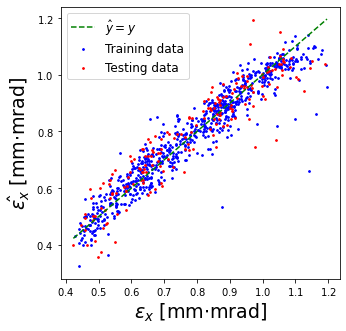

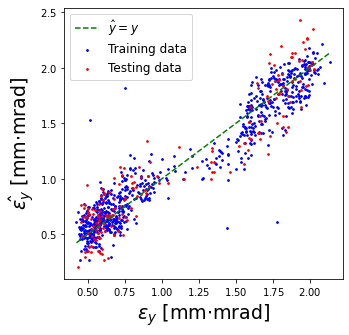

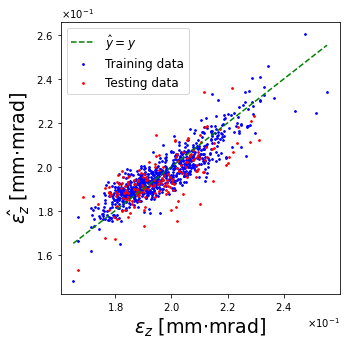

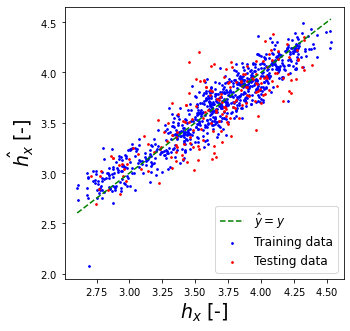

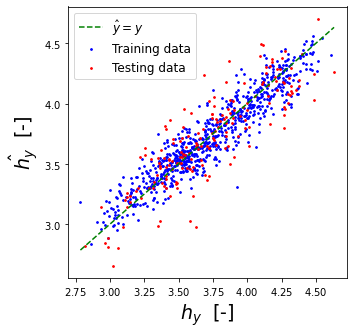

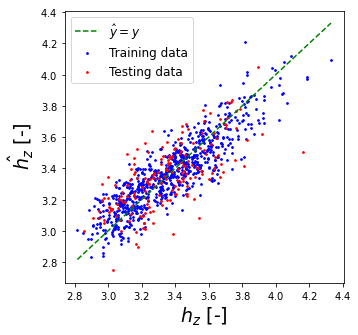

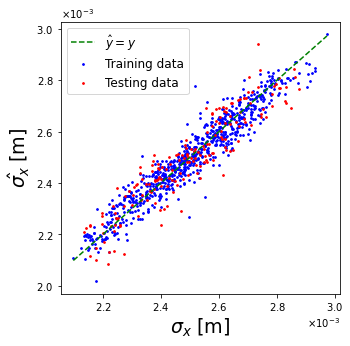

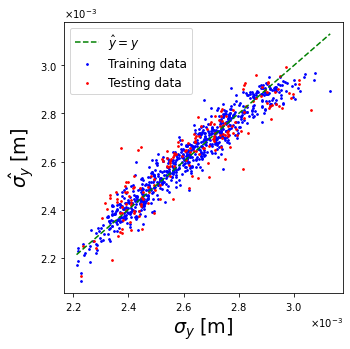

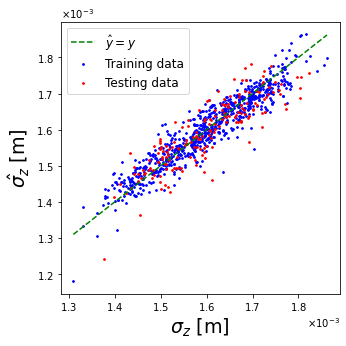

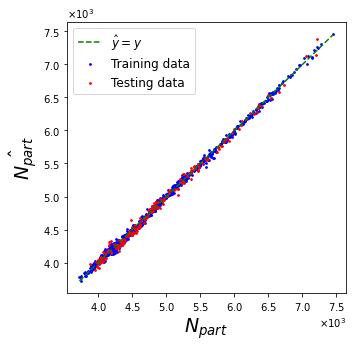

In [49]:
Rsquared_cut4, errors_cut4 = fit_eval(ycut, ytrain_cut, ytest_cut, yhat_train_cut4, yhat_test_cut4, labels_units, hat,
                                    savename=new_names,save=save_figures)

# F-test

In [50]:
import scipy.stats

#define F-test function
def f_test(x, y):
   
    # numerator needs to be the one with the larger variance
    if np.var(x)<np.var(y):
        x1 = y
        y1 = x
    else:
        x1 = x
        y1 = y
        
    # calculate f value
    
    f = np.var(x1, ddof=1)/np.var(y1, ddof=1)  
    
    # degrees of freedom (of numerator & denominator)
    
    dfn = len(x1)-1  
    dfd = len(y1)-1 
    
    # p-value --> if p < significance level alpha, then can reject null hypothesis
    p = 1-scipy.stats.f.cdf(f, dfn, dfd)
    
    return f, p

In [51]:
print('ORDER 3')

for i in range(n_qoi):
    f = f_test(ytest[i], yhat_test3[i])
    print(names_qoi[i] + ': ',f, ', Result:', end=" ")
    if f[1]<0.05:
        print('Reject null hypothesis')
    else:
        print('Keep')

ORDER 3
EMIT_X:  (1.1582963856390722, 0.15162175058457206) , Result: Keep
EMIT_Y:  (1.2731753705084923, 0.045446239742262806) , Result: Reject null hypothesis
EMIT_Z:  (1.647412808859466, 0.00024976348301519735) , Result: Reject null hypothesis
HALO_X:  (1.1999295563082397, 0.10087404605166372) , Result: Keep
HALO_Y:  (1.3717090212990004, 0.013530139996940638) , Result: Reject null hypothesis
HALO_Z:  (1.3096994650917664, 0.029503447000324368) , Result: Reject null hypothesis
RMS_X:  (1.524904945157003, 0.0016072312420332135) , Result: Reject null hypothesis
RMS_Y:  (1.5747712572146546, 0.000763962115000183) , Result: Reject null hypothesis
RMS_Z:  (1.3684138993668131, 0.01412153749988454) , Result: Reject null hypothesis
NUM_PART:  (1.0026221434072877, 0.49267807502530403) , Result: Keep


In [52]:
print('ORDER 4')

for i in range(n_qoi):
    f = f_test(ytest[i], yhat_test4[i])
    print(names_qoi[i] + ': ',f, ', Result:', end=" ")
    if f[1]<0.05:
        print('Reject null hypothesis')
    else:
        print('Keep')

ORDER 4
EMIT_X:  (1.0163234671067267, 0.45482273297967435) , Result: Keep
EMIT_Y:  (1.0921681068192668, 0.2683399275079732) , Result: Keep
EMIT_Z:  (1.3438240905175516, 0.01934210384827295) , Result: Reject null hypothesis
HALO_X:  (1.1260275295187498, 0.2027923615929259) , Result: Keep
HALO_Y:  (1.1918485669814782, 0.10947599409293285) , Result: Keep
HALO_Z:  (1.2416207888930637, 0.06483778390336525) , Result: Keep
RMS_X:  (1.0920290768264265, 0.26863398130848126) , Result: Keep
RMS_Y:  (1.064748526173331, 0.33007899937748153) , Result: Keep
RMS_Z:  (1.305827281219814, 0.030917175645463812) , Result: Reject null hypothesis
NUM_PART:  (1.0026442186037277, 0.4926165218307985) , Result: Keep


In [53]:
print('REDUCED DATA')

for i in range(n_qoi):
    f = f_test(ytest_cut[i], yhat_test_cut[i])
    print(names_qoi[i] + ': ',f, ', Result:', end=" ")
    if f[1]<0.05:
        print('Reject null hypothesis')
    else:
        print('Keep')

REDUCED DATA
EMIT_X:  (1.1789385770495502, 0.13322262060429624) , Result: Keep
EMIT_Y:  (1.0324095690238329, 0.41471300218097595) , Result: Keep
EMIT_Z:  (1.6994178872034817, 0.00018453997176193226) , Result: Reject null hypothesis
HALO_X:  (1.0964357447425277, 0.2670517283569944) , Result: Keep
HALO_Y:  (1.1732678351705024, 0.1403449302375892) , Result: Keep
HALO_Z:  (1.4764281185368668, 0.004351060759805403) , Result: Reject null hypothesis
RMS_X:  (1.2588172771375785, 0.06020861553084511) , Result: Keep
RMS_Y:  (1.4046115649516056, 0.011025567398707858) , Result: Reject null hypothesis
RMS_Z:  (1.1898945922587219, 0.12026633602725889) , Result: Keep
NUM_PART:  (1.0147841860955626, 0.46051735614127676) , Result: Keep


In [54]:
print('ORDER 4 + REDUCED')

for i in range(n_qoi):
    f = f_test(ytest_cut[i], yhat_test_cut4[i])
    print(names_qoi[i] + ': ',f, ', Result:', end=" ")
    if f[1]<0.05:
        print('Reject null hypothesis')
    else:
        print('Keep')

ORDER 4 + REDUCED
EMIT_X:  (1.0916255952822576, 0.2769015538678442) , Result: Keep
EMIT_Y:  (1.0414498377613548, 0.3919184630726238) , Result: Keep
EMIT_Z:  (1.2747711282831704, 0.050731967553897306) , Result: Keep
HALO_X:  (1.0582210058079904, 0.3511512208854026) , Result: Keep
HALO_Y:  (1.044063186038221, 0.3854304776018078) , Result: Keep
HALO_Z:  (1.249021275251575, 0.06675243923969609) , Result: Keep
RMS_X:  (1.0299256472957512, 0.4210657155271582) , Result: Keep
RMS_Y:  (1.1605219670203044, 0.1574244814934478) , Result: Keep
RMS_Z:  (1.064529612905673, 0.3363834148757813) , Result: Keep
NUM_PART:  (1.0090671359126144, 0.4756918891695241) , Result: Keep


-------------

## We can save the UQTk models to be used in the optimisation

-------------------

## We would like to have a closer look at the large emittances to be able to justify the fact that we are cutting them out of the data -- are these individual simulations realistic?

We can divide into two regions to make sure we take simulations from across the range of the large emittances.

In [56]:
closer = []

for i in range(len(yunit[0])):
    if (1.75 > yunit[0][i] >= 1.25):
        closer.append(i)

In [57]:
print(closer)

[38, 70, 73, 76, 210, 234, 396, 474, 511, 542, 616, 642, 705]


In [58]:
import random

choose = []

for i in range(5):
    choose.append(random.choice(closer))

In [59]:
closer = []

for i in range(len(yunit[0])):
    if (yunit[0][i] >= 1.75):
        closer.append(i)

In [60]:
print(closer)

[1, 5, 11, 28, 46, 48, 49, 62, 87, 91, 93, 131, 147, 153, 194, 199, 259, 267, 270, 273, 279, 283, 312, 313, 315, 326, 329, 336, 364, 417, 419, 455, 484, 515, 528, 544, 605, 627, 661, 752, 757, 769, 780, 785, 793, 807, 810, 811, 815, 824, 852, 863, 913, 984]


In [61]:
for i in range(10):
    choose.append(random.choice(closer))

In [62]:
choose

[73, 474, 474, 511, 705, 605, 811, 793, 515, 769, 810, 863, 259, 267, 11]

Choose 15 of these randomly to analyse closely. --> We can look at 5 simulations from the first region and 10 from the next.

So we will analyse outputs: [642, 73, 542, 642, 73, 62, 93, 147, 419, 279, 815, 544, 757, 811, 752].

Cf. notebook : large_emittances.ipynb for this.